In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# installing/upgrading fastai2 
!pip install --upgrade fastai

In [2]:
# installing/upgrading fastai2 
!pip install --upgrade fastbook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 4.5 MB/s eta 0:00:0000:0100:01m


In [3]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [4]:
#hide
from fastbook import *

In [5]:
path = untar_data(URLs.PETS)/'images'
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=21,
    label_func=is_cat, item_tfms=Resize(224))
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 135MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,0.152839,0.026642,0.007442,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.054021,0.025939,0.008119,00:33


In [6]:
img = PILImage.create(image_cat())
x, = first(dls.test_dl([img]))

In [7]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [8]:
hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

In [9]:
with torch.no_grad(): output = learn.model.eval()(x)

In [10]:
act = hook_output.stored[0]

In [11]:
F.softmax(output, dim=-1)

TensorImage([[0.1080, 0.8920]], device='cuda:0')

In [12]:
dls.vocab

[False, True]

In [13]:
x.shape

torch.Size([1, 3, 224, 224])

In [14]:
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

torch.Size([2, 7, 7])

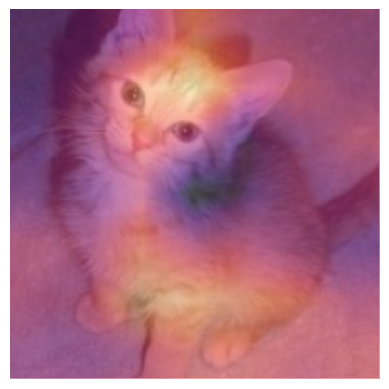

In [ ]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

In [16]:
hook.remove()

In [17]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [18]:
with Hook(learn.model[0]) as hook:
    with torch.no_grad(): output = learn.model.eval()(x.cuda())
    act = hook.stored